# Поведение пользователей мобильного приложения

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

**Цель:** проанализировать поведение пользователей мобильного приложения стартапа продуктов питания.

**Задачи:**
- Изучить воронку продаж. Узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. На каких именно.
- Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

## Изучение и предобработка файла данных 

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime as dt
from scipy import stats as st
import math as mth
from plotly import graph_objects as go


import warnings
warnings.filterwarnings('ignore')
pd.set_option("max_colwidth", 200)
import plotly.io as pio
pio.renderers.default='notebook'

Запишем датасет в переменную df

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')
    
pd.options.display.max_columns = 50

Посмотрим на первые 10 строк и общую информацию о датафрейме

In [3]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Описание данных:

`EventName` — название события;

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Данные полные, пропусков нет. Типы данных столбцов в порядке. Можно привести названия столбцов к нижнему регистру и переименовать для удобства, перевести названия событий на русский. Также необходимо преобразовать время события в привычный формат.

In [4]:
# Приводим названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

# Переименовываем названия столбцов
df = df.rename(columns={'eventname': 'event', 'deviceidhash': 'user_id', 'expid': 'exp_id'})

# Приводим столбец с временем события в привычный формат
df['eventtimestamp'] = pd.to_datetime(df['eventtimestamp'], unit='s')

# Английские названия событий
eng_event = ['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']

# Русские названия событий
rus_event = ['Главный экран', 'Покупка', 'Переход в корзину', 'Просмотр предложений', 'Обучение']

# Переменная для итерации внутри цикла
i = 0

# Замена английских названий событий на русские
for num in eng_event:
    df.loc[df['event'] == num, 'event'] = rus_event[i]
    i += 1

###  Проверка на дубликаты

Проверим данные на дубликаты:

In [5]:
# Посмотрим также на количество пользователей
print('Пользователей без проверки на дубликаты -', df['user_id'].nunique())

print('Количество дубликатов -', df.duplicated().sum())

Пользователей без проверки на дубликаты - 7551
Количество дубликатов - 413


Удалим их:

In [6]:
df = df.drop_duplicates()

print('Пользователей после удаления дубликатов -', df['user_id'].nunique())

Пользователей после удаления дубликатов - 7551


Вновь посмотрим общую информацию и количество пользователей в логе

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event           243713 non-null  object        
 1   user_id         243713 non-null  int64         
 2   eventtimestamp  243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Посмотрим на количество событий в логе, количество пользователей и среднее количество событий на пользователя.

In [8]:
# Количество событий в логе
display(df.groupby('event', as_index=False).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False))

print('Количество пользователей в логе:', df['user_id'].nunique())


print('Среднее количество событий на пользователя', 
      df.groupby('user_id', as_index=False).agg({'event': 'count'})['event'].median())

,event,user_id
0,Главный экран,119101
4,Просмотр предложений,46808
2,Переход в корзину,42668
3,Покупка,34118
1,Обучение,1018


Количество пользователей в логе: 7551
Среднее количество событий на пользователя 20.0


По итогу предобработки данных в виде исключения дубликатов располагаем 243713 событиями, 7551 пользователем со средним количеством событий 20. Дублирующиеся пользователи отсутствуют

### Определение временного периода данных

In [9]:
print('Начало периода:', df['eventtimestamp'].min())
print('Конец периода:', df['eventtimestamp'].max())
print('Временной интервал равен', (df['eventtimestamp'].max() - df['eventtimestamp'].min()))

Начало периода: 2019-07-25 04:43:36
Конец периода: 2019-08-07 21:15:17
Временной интервал равен 13 days 16:31:41


Выделим дату в отдельный столбик

In [10]:
df['date'] = pd.to_datetime(df['eventtimestamp'].dt.date)

Построим гистограмму по дате

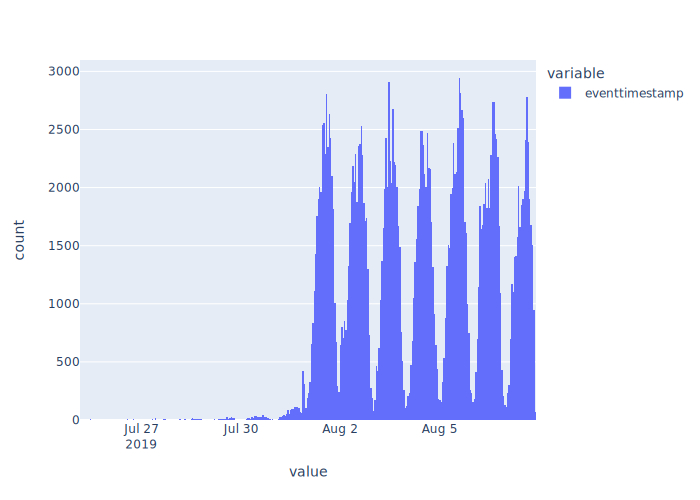

In [11]:
fig = px.histogram(df['eventtimestamp'])
fig.show('svg')

Между 25 июля и 1 августом огромная "пропасть" в данных. Возможно, в то время были сбои на серевере, работе приложения или велись технические работы и доступ к приложению имели только тестировщики.

Отбросим данные до 1 августа

In [12]:
user_c_bef = df['user_id'].nunique()
ev_c_bef = df['event'].count()

print('Пользователей до фильтрации', user_c_bef)
print('Записей (событий в логе) до фильтрации', ev_c_bef)

df = df.query('date >= "2019-08-01"')

user_c_aft = df['user_id'].nunique()
ev_c_aft = df['event'].count()

print('\nПользователей после фильтрации', user_c_aft)
print('Записей (событий в логе) после фильтрации', ev_c_aft)

print('Доля удалённых пользователей', round((100 - (user_c_aft / user_c_bef) * 100), 2))
print('Доля удалённых записей', round((100 - (ev_c_aft / ev_c_bef) * 100), 2))

Пользователей до фильтрации 7551
Записей (событий в логе) до фильтрации 243713

Пользователей после фильтрации 7534
Записей (событий в логе) после фильтрации 240887
Доля удалённых пользователей 0.23
Доля удалённых записей 1.16


### Данные о пользователях

Посмотрим на среднее количество событий на пользователя

,count,mean,std,min,25%,50%,75%,max
event,7534.0,31.973321,65.090307,1.0,9.0,19.0,37.0,2307.0


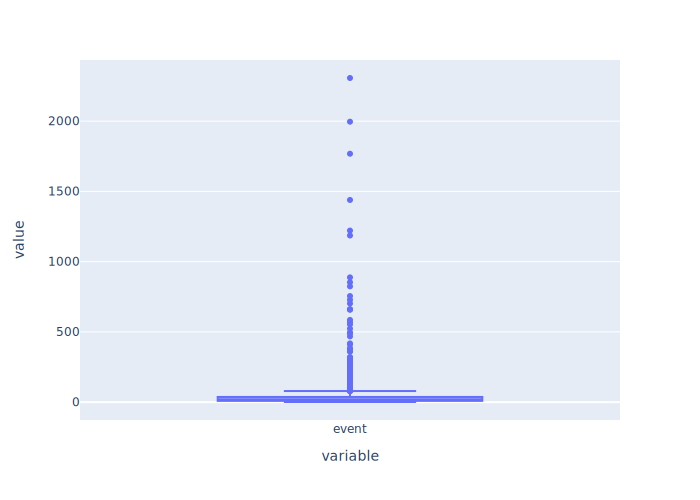

In [13]:
# Группируем пользователей и считаем для каждого число действий
user_m_event = df.groupby('user_id', as_index=False) \
                 .agg({'event': 'count'}) \
                 .sort_values(by='event', ascending=False)

display(user_m_event[['event']].describe().T)
fig = px.box(user_m_event['event'])
fig.show('svg')

Оставим топ-99% по числу совершенных действий, таким образом удалятся самые аномальные значения

In [14]:
# Определяем 99 выборочный перцентиль
t_nn = np.percentile(user_m_event['event'], 99).astype(int)

print(f'За аномальных можно принять пользователей, число совершённых действий которых более {t_nn} операций')

# Записываем в новую переменную только аномальных пользователей
user_m_event_an = user_m_event.query('event >= @t_nn').copy()

print('Количество аномальных пользователей:', len(user_m_event_an))

user_c_bef = df['user_id'].nunique()
ev_c_bef = df['event'].count()

# Получаем
val = user_m_event_an['user_id'].values
df = df.query('user_id not in @val')

print('Пользователей после очистки -', df['user_id'].nunique())
print('Записей после очистки', df['event'].count())

user_c_aft = df['user_id'].nunique()
ev_c_aft = df['event'].count()
print('Доля удалённых пользователей', round((100 - (user_c_aft / user_c_bef) * 100), 2))
print('Доля удалённых записей', round((100 - (ev_c_aft / ev_c_bef) * 100), 2))

За аномальных можно принять пользователей, число совершённых действий которых более 201 операций
Количество аномальных пользователей: 76
Пользователей после очистки - 7458
Записей после очистки 206615
Доля удалённых пользователей 1.01
Доля удалённых записей 14.23


Проверим, есть ли у нас пользователи из всех экспериментальных групп:

In [15]:
exp_gr_info = df.groupby('exp_id', as_index=False).agg({'user_id': 'nunique'})
exp_gr_info

,exp_id,user_id
0,246,2456
1,247,2491
2,248,2511


Все группы представлены

### Выводы

По итогу изучения и предобработки данных можно отметить следующее:

Мы располагаем данными за период с 25 июля по 7 августа 2019 года. По неизвестным нам причинам данные с 25 июля 1 августа дают скошенность по отношению к последующим данным. Было принято решение отбросить данные за эти даты. Количество пользователей после проделанных операций сократилось на 93. Всего осталось 7458 пользователей и 206615 записей.

* В 246 контрольной группе 2456 пользователей;
* В 247 контрольной группе 2491 пользователей;
* В 248 контрольной группе 2511 пользователей.

Все группы пользователей представлены.

## Анализ данных

### Анализ действий пользователей

Посмотрим, какие события есть в логах и как часто они встречаются:

In [16]:
df['event'].value_counts().to_frame()

,event
Главный экран,113264
Просмотр предложений,40956
Переход в корзину,29250
Покупка,22164
Обучение,981


Удалим этап "обучение", так как заданием не предполагается 

In [17]:
df = df.query('event != "Обучение"')

#### Выводы

Самое частое событие из представленных - открытие главного экрана.
Наименее частое - прохождение обучения.

### Воронка событий 

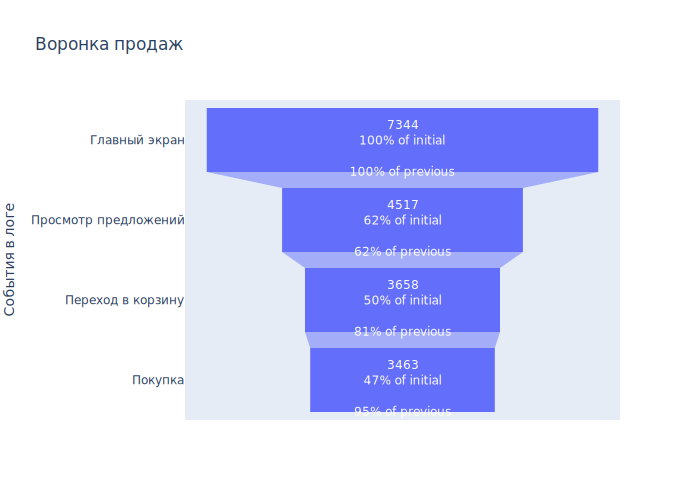

In [18]:
funnel_gr = df.groupby(['event'], as_index=False) \
              .agg({'user_id': 'nunique'}) \
              .sort_values(by='user_id', ascending=False) \
              .rename(columns={'user_id': 'amount'})

fig = go.Figure(
    go.Funnel(
        y=funnel_gr['event'],
        x=funnel_gr['amount'],
        textinfo = 'value + percent initial + percent previous'
    )
)
fig.update_layout(title='Воронка продаж')
fig.update_yaxes(title_text='События в логе')   
fig.show('svg')

#### Выводы

* Последовательность событий, выстроенная воронкой похожа на правду. Исключение - прохождение обучения. Вероятно, этот этап является опциональным и потому попал в самый низ получившейся воронки событий, всего 11% пользователей его проходят;

* В глаза сразу же бросается несоответствие количества пользователей с начальным действием - просмотром главного экрана (общее количество пользователей - 7458, просмотревших главный экран - 7344). Возможно, это пользователи, которые перешли сразу на страницу просмотра предложений через нативную рекламу, ссылку от друга и т.п.;

* Больше всего пользователей теряется на этапе перехода с главного экрана на просмотр предложений (61,5%);

* До покупки доходит 3463 пользователя (46,4%).

### Выводы 

Построена воронка событий, частота событий в логах. Данные обоих построений выглядят правдоподобно, можно приступать к изучению результатов эксперимента.

## Изучение результатов эксперимента

Взглянем ещё раз на количество пользователей в каждой экспериментальной группе

In [19]:
exp_gr_info

,exp_id,user_id
0,246,2456
1,247,2491
2,248,2511


Запишем их в переменные:

Проверим, нет ли пользователей, попавших в несколько экспериментальных групп

In [20]:
df.groupby('user_id', as_index=False).agg({'exp_id': 'nunique'})['exp_id'].value_counts().to_frame()

,exp_id
1,7454


Все пользователи состоят только в одной группе. Пользователей, попавших в несколько экспериментальных групп нет.

Напишем функцию, проверяющую гипотезу о равенстве

In [21]:
def test_func(gr_on, gr_tw, ev):
    
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([df.query('exp_id == @gr_on & event == @ev')['user_id'].nunique(),
                          df.query('exp_id == @gr_tw & event == @ev')['user_id'].nunique()])
    
    trials = np.array([df.query('exp_id == @gr_on')['user_id'].nunique(),
                       df.query('exp_id == @gr_tw')['user_id'].nunique()])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('\n', ev)

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

### Различие между группами 246 и 247

**Введем нулевую и альтернативные гипотезы для этого и последующих сравнений**:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Различий в конверсии между группами нет}\\
   H_1 :\text{Различия в конверсии между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Рассчитаем p-value. Если p-value будет меньше выбранного уровня значимости ($\alpha = 0.05$), то будут основания отвергнуть нулевую гипотезу в пользу альтернативной. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Сравним 2 контрольные группы для A/A экперимента на примере совершения покупки:

In [22]:
test_func(246, 247, 'Покупка')


 Покупка
p-значение:  0.13574398826607448
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проделаем то же самое для остальных событий

In [23]:
for num in df['event'].unique():
    test_func(246, 247, num)


 Главный экран
p-значение:  0.6674277103003372
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Просмотр предложений
p-значение:  0.2767654959510515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Переход в корзину
p-значение:  0.2628160759054654
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Покупка
p-значение:  0.13574398826607448
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Выводы:

Различий между группами 246 и 247 нет.

### Различие между группами 246 и 248 (экспериментальная)

In [24]:
for num in df['event'].unique():
    test_func(246, 248, num)


 Главный экран
p-значение:  0.2814719389970719
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Просмотр предложений
p-значение:  0.22374437294463578
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Переход в корзину
p-значение:  0.08551270605955108
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Покупка
p-значение:  0.22875623127967426
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Выводы:

Различий между группами 246 и 248 (экспериментальной) нет.

### Различие между группами 247 и 248 (экспериментальная)

In [25]:
for num in df['event'].unique():
    test_func(247, 248, num)


 Главный экран
p-значение:  0.5151100783020421
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Просмотр предложений
p-значение:  0.8985730856764382
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Переход в корзину
p-значение:  0.5485507037235671
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Покупка
p-значение:  0.7701611050267243
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Выводы:

Различий между группами 247 и 248 (экспериментальной) нет.

### Различие между группами 246 и 247 (объединённая) и 248 (экспериментальная)

In [26]:
for num in df['event'].unique():
    test_func([246, 247], 248, num)


 Главный экран
p-значение:  0.3119454749745101
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Просмотр предложений
p-значение:  0.43945868001043786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Переход в корзину
p-значение:  0.18112712794559194
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Покупка
p-значение:  0.6011006343280214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Выводы:

Различий между группами 246 и 247 (объединённая) и 248 (экспериментальной) нет.

### Вывод

Проведён анализ между группами:

- 246 и 247

- 246 и 248

- 247 и 248

- 246 и 247 (объединённая) и 248

Различий между всеми комбинациями групп нет. Изменение шрифта не принесёт никаких изменений.

Уровень значимости при сравнении различий был установлен в 5%.

Как правило, уровень значимости принимают равным 0,05: это означает, что на действующей модели лишь в 5% случаев есть вероятность выявить ложную разницу между двумя вариациями (то есть пятипроцентная вероятность ошибки). Про эту общепринятую константу обычно говорят “достоверность более 95%”. Большинство специалистов по проведению тестирований (как и большинство инструментов, доступных на сегодняшний день) довольствуются этим первым параметром.

## Общий вывод

**Перед анализом данных и изучением результатов эксперимента была проведена предобработка данных:**

    Мы располагаем данными за период с 25 июля по 7 августа 2019 года. По неизвестным нам причинам данные с 25 июля 1 августа дают скошенность по отношению к последующим данным. Было принято решение отбросить данные за эти даты. Количество пользователей после проделанных операций сократилось на 93. Всего осталось 7458 пользователей и 206615 записей.

    * В 246 контрольной группе 2456 пользователей;
    * В 247 контрольной группе 2491 пользователей;
    * В 248 контрольной группе 2511 пользователей.

    Все группы пользователей представлены. Пользователей, попавших в несколько групп - нет.

**Далее был проведен анализ действий пользователей:**

    Была построена воронка событий, частота событий в логах. Данные обоих построений выглядят правдоподобно.

    Последовательность событий, выстроенная воронкой похожа на правду. Исключение - прохождение обучения. Вероятно, этот     этап является опциональным и потому попал в самый низ получившейся воронки событий, всего 11% пользователей его         проходят;

    В глаза сразу же бросается несоответствие количества пользователей с начальным действием - просмотром главного экрана (общее количество пользователей - 7458, просмотревших главный экран - 7344). Возможно, это пользователи, которые перешли сразу на страницу просмотра предложений через нативную рекламу, ссылку от друга и т.п.;

    Больше всего пользователей теряется на этапе перехода с главного экрана на просмотр предложений (61,5%);

    До покупки доходит 3463 пользователя (46,4%).
    
**В завершении изучены результаты эксперимента:**

    Сравнению подверглись все комбинации групп. По итогам сравнения различий между группами нет. Менеджеров можно успокоить, изменение шрифта не принёсёт "непривычности" пользователям, ровно как и бОльшей выручки для компании.